In [1]:
#importing the libraries
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
from tensorflow.keras.preprocessing import image

In [2]:
# here we are calling pretrained model from keras applications ie EfficientNetB0

In [3]:
efficient_net=tf.keras.applications.EfficientNetB0()

In [1]:

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Conv2D,MaxPool2D,Flatten,GlobalAveragePooling2D,Dropout

In [5]:
efficient_net.summary()

Model: "efficientnetb0"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
rescaling (Rescaling)           (None, 224, 224, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
normalization (Normalization)   (None, 224, 224, 3)  7           rescaling[0][0]                  
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, 225, 225, 3)  0           normalization[0][0]              
_____________________________________________________________________________________

In [6]:
# global  average pooling2d is flattening layer and till the end

In [2]:
# extracting the base model 
base_model=tf.keras.applications.EfficientNetB0(input_shape=(224,224,3),include_top=False) 
base_model.summary()

NameError: name 'tf' is not defined

In [8]:
# from base model summary, the flatten and dense layers are removed
# we need to freeze trainable weights

In [9]:
base_model.trainable

True

In [10]:
base_model.trainable=False # deliberately making it False

In [11]:
base_model.summary()

Model: "efficientnetb0"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
rescaling_1 (Rescaling)         (None, 224, 224, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
normalization_1 (Normalization) (None, 224, 224, 3)  7           rescaling_1[0][0]                
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, 225, 225, 3)  0           normalization_1[0][0]            
_____________________________________________________________________________________

In [12]:
# all weights are now freezed as Trainable parameters are zero

In [13]:
# now designing dense layers

In [14]:
transfer_model=Sequential()
transfer_model.add(base_model)
#transfer_model.add(Flatten())
transfer_model.add(GlobalAveragePooling2D())
transfer_model.add(Dense(units=512,activation='relu'))
transfer_model.add(Dropout(.2))
transfer_model.add(Dense(units=64,activation='relu'))
transfer_model.add(Dropout(.1))
transfer_model.add(Dense(units=15,activation='softmax'))


In [15]:
transfer_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnetb0 (Functional)  (None, 7, 7, 1280)        4049571   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 512)               655872    
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                32832     
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 15)                9

In [17]:
# global average poolingis used as it gives less parameters

In [ ]:
# preparing train and test data generator

In [18]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen=ImageDataGenerator(preprocessing_function=tf.keras.applications.efficientnet.preprocess_input,
                  rotation_range=45,
                  width_shift_range=0.2,
                  height_shift_range=0.2,
                  shear_range=0.2, # shrink
                  zoom_range=0.2,
                  horizontal_flip=True,# becareful with flip ,dont flip numbers
                  fill_mode='reflect'
                   
                  )
test_datagen=ImageDataGenerator(preprocessing_function=tf.keras.applications.efficientnet.preprocess_input)

In [19]:
train_set=train_datagen.flow_from_directory("C:\\Users\\warda\\Spider_CNN\\train",
                                 target_size=(224,224),
                                 batch_size=32,
                                 class_mode='categorical') # for binary give class_mode=binary

test_set=test_datagen.flow_from_directory("C:\\Users\\warda\\Spider_CNN\\test",
                                 target_size=(224,224),
                                 batch_size=32,
                                 class_mode='categorical')

Found 2185 images belonging to 15 classes.
Found 150 images belonging to 15 classes.


In [20]:
#compile the model with Adam optimizer and metric of accuracy
transfer_model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

In [21]:
# calling EarlyStoppin and ModelCheckpoint to save the best model
from tensorflow.keras.callbacks import EarlyStopping,ModelCheckpoint

keras_callback=[EarlyStopping(monitor='val_loss',mode='min',patience=5,min_delta=.01),
ModelCheckpoint('C:\\Users\\warda\\Spiderbest_transfer',monitor='val_loss',save_best_only=True)] 

In [22]:
# fitting the model
transfer_model.fit(train_set,
                      steps_per_epoch=2185//32, # how many times in one epoch weights need to be updated?
                      epochs=10, # try 20
                      validation_data=test_set,
                      validation_steps=150//32,
                  callbacks=keras_callback)

Epoch 1/10
68/68 [==============================] - ETA: 0s - loss: 1.0872 - accuracy: 0.6410WARNING:tensorflow:From C:\Users\warda\anaconda3\envs\tf_env\lib\site-packages\tensorflow\python\training\tracking\tracking.py:111: Model.state_updates (from tensorflow.python.keras.engine.training) is deprecated and will be removed in a future version.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: C:\Users\warda\Spiderbest_transfer\assets
68/68 [==============================] - 120s 2s/step - loss: 1.0872 - accuracy: 0.6410 - val_loss: 0.4201 - val_accuracy: 0.8203
Epoch 2/10
68/68 [==============================] - 116s 2s/step - loss: 0.5169 - accuracy: 0.8208 - val_loss: 0.2646 - val_accuracy: 0.8828
Epoch 3/10
68/68 [==============================] - 116s 2s/step - loss

In [23]:
#evaluating the model
transfer_model.evaluate(test_set)

5/5 [==============================] - 4s 717ms/step - loss: 0.0942 - accuracy: 0.9600


[0.09416989982128143, 0.9599999785423279]

In [ ]:
# getting test data again to make confusionn matrix

In [29]:
test_datagen = ImageDataGenerator(preprocessing_function=tf.keras.applications.efficientnet.preprocess_input)

test_set=test_datagen.flow_from_directory('C:\\Users\\warda\\Spider_CNN\\test',
                                 target_size=(128,128),
                                 shuffle=False,
                                 batch_size=1,     
                                 class_mode='categorical') # binary for covid-noncovid(2 classes)

filenames = test_set.filenames
nb_samples = len(filenames)

predict = transfer_model.predict_generator(test_set,steps = nb_samples)

Found 150 images belonging to 15 classes.


In [30]:
ypred=predict.argmax(axis=1)

yact=test_set.classes

<AxesSubplot:>

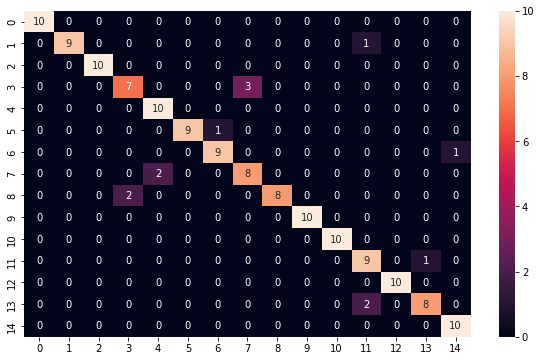

In [31]:
from sklearn.metrics import confusion_matrix
import seaborn as sb
plt.figure(figsize=(10,6))
sb.heatmap(confusion_matrix(yact,ypred),annot=True,fmt='.0f')

In [32]:
train_set.class_indices

{'Black Widow': 0,
 'Blue Tarantula': 1,
 'Bold Jumper': 2,
 'Brown Grass Spider': 3,
 'Brown Recluse Spider': 4,
 'Deinopis Spider': 5,
 'Golden Orb Weaver': 6,
 'Hobo Spider': 7,
 'Huntsman Spider': 8,
 'Ladybird Mimic Spider': 9,
 'Peacock Spider': 10,
 'Red Knee Tarantula': 11,
 'Spiny-backed Orb-weaver': 12,
 'White Kneed Tarantula': 13,
 'Yellow Garden Spider': 14}

In [ ]:
# testing the model

In [ ]:

import numpy as np

In [ ]:
test_img=image.load_img('C:\\Users\\warda\\Spider_CNN\\example\\1.jpg',target_size=(224,224))


test_img1=image.img_to_array(test_img)
test_img1=tf.keras.applications.efficientnet.preprocess_input(test_img1)
#expand dimensions 
# predict, test the model, cnn will accept input in four dimensions

test_img2=np.expand_dims(test_img1,axis=0) # expand dimension at 0 or first position (1, 128, 128, 3) here 1 because
# just one image for testing
ypred=transfer_model.predict(test_img2)
print(train_set.class_indices)
print("The test image class is",ypred.argmax())
class_name=train_set.class_indices
pos=np.array(list(class_name.values()))==ypred.argmax()
name=np.array(list(class_name.keys()))
print("The predicted class name is:")
print(name[pos][0])
test_img

In [33]:
from sklearn.metrics import classification_report
print(classification_report(yact,ypred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        10
           1       1.00      0.90      0.95        10
           2       1.00      1.00      1.00        10
           3       0.78      0.70      0.74        10
           4       0.83      1.00      0.91        10
           5       1.00      0.90      0.95        10
           6       0.90      0.90      0.90        10
           7       0.73      0.80      0.76        10
           8       1.00      0.80      0.89        10
           9       1.00      1.00      1.00        10
          10       1.00      1.00      1.00        10
          11       0.75      0.90      0.82        10
          12       1.00      1.00      1.00        10
          13       0.89      0.80      0.84        10
          14       0.91      1.00      0.95        10

    accuracy                           0.91       150
   macro avg       0.92      0.91      0.91       150
weighted avg       0.92   

In [ ]:
# Changing the architecture by unfreezing Convolutional Layers to get them train

In [34]:
base_model=tf.keras.applications.EfficientNetB0(input_shape=(128,128,3),include_top=False) 

In [35]:
base_model.layers 

In [38]:
for layer in base_model.layers[:200]:
    layer.trainable=False

In [40]:
for layer in base_model.layers:
    print(layer.name,layer.trainable)

input_3 False
rescaling_2 False
normalization_2 False
stem_conv_pad False
stem_conv False
stem_bn False
stem_activation False
block1a_dwconv False
block1a_bn False
block1a_activation False
block1a_se_squeeze False
block1a_se_reshape False
block1a_se_reduce False
block1a_se_expand False
block1a_se_excite False
block1a_project_conv False
block1a_project_bn False
block2a_expand_conv False
block2a_expand_bn False
block2a_expand_activation False
block2a_dwconv_pad False
block2a_dwconv False
block2a_bn False
block2a_activation False
block2a_se_squeeze False
block2a_se_reshape False
block2a_se_reduce False
block2a_se_expand False
block2a_se_excite False
block2a_project_conv False
block2a_project_bn False
block2b_expand_conv False
block2b_expand_bn False
block2b_expand_activation False
block2b_dwconv False
block2b_bn False
block2b_activation False
block2b_se_squeeze False
block2b_se_reshape False
block2b_se_reduce False
block2b_se_expand False
block2b_se_excite False
block2b_project_conv False

In [41]:
# model architecture
transfer_model_t=Sequential()
transfer_model_t.add(base_model)
#transfer_model.add(Flatten()) # increases weights and time consuming
transfer_model_t.add(GlobalAveragePooling2D())
transfer_model_t.add(Dense(units=512,activation='relu'))
transfer_model_t.add(Dropout(.2))
transfer_model_t.add(Dense(units=64,activation='relu'))
transfer_model_t.add(Dropout(.1))
transfer_model_t.add(Dense(units=15,activation='softmax'))

In [43]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen=ImageDataGenerator(preprocessing_function=tf.keras.applications.efficientnet.preprocess_input,
                  rotation_range=45,
                  width_shift_range=0.2,
                  height_shift_range=0.2,
                  shear_range=0.2, # shrink
                  zoom_range=0.2,
                  horizontal_flip=True,# becareful with flip dont flip numbers
                  fill_mode='reflect'
                   
                  )
test_datagen=ImageDataGenerator(preprocessing_function=tf.keras.applications.efficientnet.preprocess_input)

In [44]:
train_set=train_datagen.flow_from_directory("C:\\Users\\warda\\Spider_CNN\\train",
                                 target_size=(224,224),
                                 batch_size=32,
                                 class_mode='categorical') # for binary give class_mode=binary

test_set=test_datagen.flow_from_directory("C:\\Users\\warda\\Spider_CNN\\test",
                                 target_size=(224,224),
                                 batch_size=32,
                                 class_mode='categorical')

Found 2185 images belonging to 15 classes.
Found 150 images belonging to 15 classes.


In [46]:
transfer_model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

In [47]:
from tensorflow.keras.callbacks import EarlyStopping,ModelCheckpoint

keras_callback=[EarlyStopping(monitor='val_loss',mode='min',patience=5,min_delta=.01),
ModelCheckpoint('C:\\Users\\warda\\Spiderbest_transfer',monitor='val_loss',save_best_only=True)] 

In [48]:
transfer_model.fit(train_set,
                      steps_per_epoch=2185//32, # how many times in one epoch weights need to be updated?
                      epochs=10, # try 20
                      validation_data=test_set,
                      validation_steps=150//32,
                  callbacks=keras_callback)

Epoch 1/10
68/68 [==============================] - 123s 2s/step - loss: 0.2491 - accuracy: 0.9136 - val_loss: 0.1014 - val_accuracy: 0.9688
Epoch 2/10
68/68 [==============================] - 85s 1s/step - loss: 0.2150 - accuracy: 0.9206 - val_loss: 0.1097 - val_accuracy: 0.9766
Epoch 3/10
68/68 [==============================] - 84s 1s/step - loss: 0.2135 - accuracy: 0.9266 - val_loss: 0.1067 - val_accuracy: 0.9844
Epoch 4/10
68/68 [==============================] - 84s 1s/step - loss: 0.2064 - accuracy: 0.9252 - val_loss: 0.1202 - val_accuracy: 0.9766
Epoch 5/10
68/68 [==============================] - 122s 2s/step - loss: 0.1823 - accuracy: 0.9373 - val_loss: 0.0628 - val_accuracy: 0.9922
Epoch 6/10
68/68 [==============================] - 86s 1s/step - loss: 0.2000 - accuracy: 0.9289 - val_loss: 0.0956 - val_accuracy: 0.9375
Epoch 7/10
68/68 [==============================] - 87s 1s/step - loss: 0.1881 - accuracy: 0.9350 - val_loss: 0.1038 - val_accuracy: 0.9688
Epoch 8/10
68/68 [

In [49]:
transfer_model.evaluate(test_set)

5/5 [==============================] - 4s 739ms/step - loss: 0.0956 - accuracy: 0.9733


[0.09559016674757004, 0.9733333587646484]

In [50]:
test_datagen = ImageDataGenerator(preprocessing_function=tf.keras.applications.efficientnet.preprocess_input)

test_set=test_datagen.flow_from_directory('C:\\Users\\warda\\Spider_CNN\\test',
                                 target_size=(128,128),
                                 shuffle=False,
                                 batch_size=1,     
                                 class_mode='categorical') # binary for covid-noncovid(2 classes)

filenames = test_set.filenames
nb_samples = len(filenames)

predict = transfer_model.predict_generator(test_set,steps = nb_samples)

Found 150 images belonging to 15 classes.


In [51]:
ypred=predict.argmax(axis=1)

yact=test_set.classes

<AxesSubplot:>

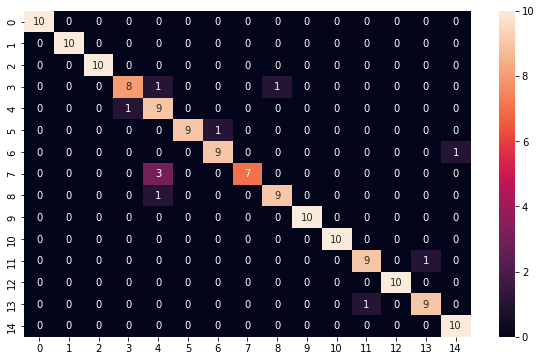

In [52]:
from sklearn.metrics import confusion_matrix
import seaborn as sb
plt.figure(figsize=(10,6))
sb.heatmap(confusion_matrix(yact,ypred),annot=True,fmt='.0f')

In [ ]:
# we can see that transfer learning with some trainable weights for convolutional layers improves the overall
#accuracy.